<a href="https://colab.research.google.com/github/TheRufael/CS770-Assignments/blob/main/Assignment_three_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Project Overview — Question 3

# 0. Set a fixed seed for reproducibility.
# 1. Loaded Fashion MNIST and created a consistent train–validation split.
# 2. Built tf.data pipelines with deterministic shuffle and batching.
# 3. Defined data-augmentation transformations and previewed augmented samples.
# 4. Built two model types:
#      - Basic CNN
#      - Deep CNN
#    Each model can run with or without augmentation.
# 5. Implemented training and evaluation helpers (optimizer selection, logging, metrics).
# 6. Trained four runs:
#      - Basic CNN without augmentation
#      - Basic CNN with augmentation
#      - Deep CNN without augmentation
#      - Deep CNN with augmentation
# 7. Collected accuracy, training time, and model statistics.
# 8. Summarized results in a comparison table.
# 9. Plotted learning curves for all four configurations.
# 10. Generated confusion matrices and per-class performance reports.



In [ ]:
# 1) Setup and reproducibility

SEED = 42  # single seed used in every experiment

import os, time, random, math
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, utils

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Fix random state for Python, NumPy, and TensorFlow
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)

# Try to turn on deterministic behavior where supported
try:
    tf.config.experimental.enable_op_determinism(True)
except Exception:
    pass

# Allow dynamic GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

print("TensorFlow", tf.__version__)
print("NumPy", np.__version__)
try:
    import sklearn
    print("Scikit-learn", sklearn.__version__)
except Exception:
    pass
print("GPU devices", tf.config.list_physical_devices("GPU"))

TensorFlow 2.19.0
NumPy 2.0.2
Scikit-learn 1.6.1
GPU devices [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# 2) Load data and create fixed split

# Load Fashion MNIST from Keras datasets
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize to [0, 1] and add channel dimension
x_train_full = (x_train_full.astype("float32") / 255.0)[..., None]
x_test       = (x_test.astype("float32")       / 255.0)[..., None]

# One-hot labels
NUM_CLASSES = 10
y_train_full_oh = utils.to_categorical(y_train_full, NUM_CLASSES)
y_test_oh       = utils.to_categorical(y_test, NUM_CLASSES)

# Fixed 80/20 train–validation split with stratification
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full,
    y_train_full_oh,
    test_size=0.20,
    random_state=SEED,
    stratify=y_train_full
)

INPUT_SHAPE = (28, 28, 1)
BATCH_SIZE = 64
EPOCHS = 30

print("Train shape", x_train.shape, "Val shape", x_val.shape, "Test shape", x_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train shape (48000, 28, 28, 1) Val shape (12000, 28, 28, 1) Test shape (10000, 28, 28, 1)


In [ ]:
# 3) Build tf.data pipelines

AUTOTUNE = tf.data.AUTOTUNE

# Deterministic shuffle with the same seed
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(60000, seed=SEED, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test_oh))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

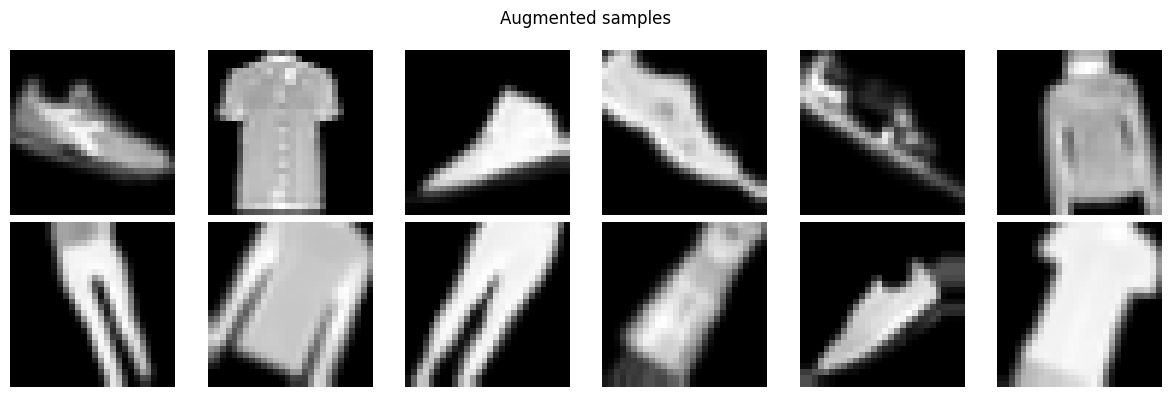

In [ ]:
# 4) Define augmentation and preview samples
# Purpose
# - Improve generalization by teaching invariance to small flips, rotations, shifts, zoom, and contrast changes
# Design
# - Light ranges to avoid losing detail in 28x28 images
# Reproducibility
# - Pass seed=SEED to each random layer

def build_augmentation():
    return keras.Sequential(
        [
            layers.RandomFlip("horizontal", seed=SEED),
            layers.RandomRotation(0.10, fill_mode="nearest", seed=SEED),
            layers.RandomTranslation(0.10, 0.10, fill_mode="nearest", seed=SEED),
            layers.RandomZoom(0.10, fill_mode="nearest", seed=SEED),
            layers.RandomContrast(0.2, seed=SEED),
        ],
        name="data_augmentation",
    )

def preview_augmentations(x_batch, n=12):
    # Show a grid of augmented samples to verify that transforms look reasonable
    aug = build_augmentation()
    x_aug = aug(x_batch, training=True)  # force randomness for preview

    n = min(n, x_batch.shape[0])
    cols = 6
    rows = int(math.ceil(n / cols))
    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(x_aug[i].numpy().squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle("Augmented samples")
    plt.tight_layout()
    plt.show()

# One quick preview
for xb, yb in train_ds.take(1):
    preview_augmentations(xb[:12])
    break

In [ ]:
# 5) Build models
# define one builder for the basic CNN and one for the deep CNN.
# Both accept use_aug=True to insert the augmentation module at the input.
# keep BatchNorm after conv layers and use ReLU. Softmax at the head.

def build_basic_cnn(cfg, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, use_aug=False):
    """Basic CNN with 1–2 conv blocks."""
    x_in = layers.Input(shape=input_shape)
    x = x_in

    if use_aug:
        x = build_augmentation()(x, training=True)

    # Block 1
    x = layers.Conv2D(cfg["f1"], cfg["k"], padding="same")(x)
    if cfg.get("bn", True):
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)

    # Optional Block 2
    if cfg.get("use_block2", True):
        x = layers.Conv2D(cfg["f2"], cfg["k"], padding="same")(x)
        if cfg.get("bn", True):
            x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.MaxPooling2D(2)(x)

    if cfg.get("drop_conv", 0.0) > 0:
        x = layers.Dropout(cfg["drop_conv"])(x)

    x = layers.Flatten()(x)
    x = layers.Dense(cfg.get("dense", 128), activation="relu")(x)
    if cfg.get("drop_dense", 0.0) > 0:
        x = layers.Dropout(cfg["drop_dense"])(x)

    out = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    return models.Model(x_in, out, name=f"basic_cnn_{'aug' if use_aug else 'plain'}")


def build_deep_cnn(cfg, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, use_aug=False):
    """Deep CNN with 3–4 conv blocks."""
    x_in = layers.Input(shape=input_shape)
    x = x_in

    if use_aug:
        x = build_augmentation()(x, training=True)

    for f in cfg["filters"]:
        x = layers.Conv2D(f, cfg["k"], padding="same")(x)
        if cfg.get("bn", True):
            x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.MaxPooling2D(2)(x)
        if cfg.get("drop_block", 0.0) > 0:
            x = layers.Dropout(cfg["drop_block"])(x)

    if cfg.get("head", "gap") == "gap":
        x = layers.GlobalAveragePooling2D()(x)
    else:
        x = layers.Flatten()(x)

    if cfg.get("dense", 128) > 0:
        x = layers.Dense(cfg["dense"], activation="relu")(x)
        if cfg.get("drop_dense", 0.0) > 0:
            x = layers.Dropout(cfg["drop_dense"])(x)

    out = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    return models.Model(x_in, out, name=f"deep_cnn_{'aug' if use_aug else 'plain'}")


# Default configs chosen to focus on augmentation impact, not tuning
BASIC_CFG = {
    "f1": 32,
    "f2": 64,
    "k": 3,
    "bn": True,
    "use_block2": True,
    "drop_conv": 0.0,
    "dense": 128,
    "drop_dense": 0.0,
}
DEEP_CFG = {
    "filters": [32, 64, 128],  # you can add a 4th block if needed: [32, 64, 128, 128]
    "k": 3,
    "bn": True,
    "drop_block": 0.0,
    "head": "gap",
    "dense": 128,
    "drop_dense": 0.0,
}


In [ ]:
# 6) Train and evaluate helpers

def make_optimizer(name="adam", lr=1e-3):
    if name == "adam":
        return optimizers.Adam(learning_rate=lr)
    if name == "sgd_m":
        return optimizers.SGD(learning_rate=lr, momentum=0.9)
    return optimizers.Adam(learning_rate=lr)

def compile_model(model, opt_name="adam", lr=1e-3):
    model.compile(
        optimizer=make_optimizer(opt_name, lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

def train_one(model, train_ds, val_ds, epochs):
    start = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=2)
    secs = int(time.time() - start)
    return hist, secs

def evaluate_acc(model, ds):
    _, acc = model.evaluate(ds, verbose=0)
    return float(acc)

def plot_curves(history_list, labels, title):
    plt.figure(figsize=(12, 4))
    # Accuracy
    plt.subplot(1, 2, 1)
    for h, lab in zip(history_list, labels):
        plt.plot(h.history["accuracy"], label=f"{lab} Train")
        plt.plot(h.history["val_accuracy"], label=f"{lab} Val")
    plt.title(f"{title} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    # Loss
    plt.subplot(1, 2, 2)
    for h, lab in zip(history_list, labels):
        plt.plot(h.history["loss"], label=f"{lab} Train")
        plt.plot(h.history["val_loss"], label=f"{lab} Val")
    plt.title(f"{title} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

CLASS_NAMES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def plot_confusion(model, ds, y_true_oh, title):
    y_true = np.argmax(y_true_oh, axis=1)
    y_pred = np.argmax(model.predict(ds, verbose=0), axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=False, cmap="Blues", fmt="d",
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [ ]:
# 7) Train and evaluate four runs

results = []
artifacts = {}  # store models and histories for plots

# Basic CNN without augmentation
tf.keras.backend.clear_session()
m_b_plain = build_basic_cnn(BASIC_CFG, use_aug=False)
compile_model(m_b_plain, "adam", 1e-3)
h_b_plain, t_b_plain = train_one(m_b_plain, train_ds, val_ds, EPOCHS)
metrics_b_plain = {
    "train_acc": h_b_plain.history["accuracy"][-1],
    "val_acc":   h_b_plain.history["val_accuracy"][-1],
    "test_acc":  evaluate_acc(m_b_plain, test_ds),
}
results.append({
    "Model": "Basic CNN",
    "Depth": "1-2 blocks",
    "Augmentation": "No",
    "Train Acc": round(metrics_b_plain["train_acc"], 4),
    "Val Acc":   round(metrics_b_plain["val_acc"],   4),
    "Test Acc":  round(metrics_b_plain["test_acc"],  4),
    "Train Time (sec)": t_b_plain,
    "Params": m_b_plain.count_params(),
})
artifacts["basic_plain"] = {"model": m_b_plain, "hist": h_b_plain}

# Basic CNN with augmentation
tf.keras.backend.clear_session()
m_b_aug = build_basic_cnn(BASIC_CFG, use_aug=True)
compile_model(m_b_aug, "adam", 1e-3)
h_b_aug, t_b_aug = train_one(m_b_aug, train_ds, val_ds, EPOCHS)
metrics_b_aug = {
    "train_acc": h_b_aug.history["accuracy"][-1],
    "val_acc":   h_b_aug.history["val_accuracy"][-1],
    "test_acc":  evaluate_acc(m_b_aug, test_ds),
}
results.append({
    "Model": "Basic CNN",
    "Depth": "1-2 blocks",
    "Augmentation": "Yes",
    "Train Acc": round(metrics_b_aug["train_acc"], 4),
    "Val Acc":   round(metrics_b_aug["val_acc"],   4),
    "Test Acc":  round(metrics_b_aug["test_acc"],  4),
    "Train Time (sec)": t_b_aug,
    "Params": m_b_aug.count_params(),
})
artifacts["basic_aug"] = {"model": m_b_aug, "hist": h_b_aug}

# Deep CNN without augmentation
tf.keras.backend.clear_session()
m_d_plain = build_deep_cnn(DEEP_CFG, use_aug=False)
compile_model(m_d_plain, "adam", 1e-3)
h_d_plain, t_d_plain = train_one(m_d_plain, train_ds, val_ds, EPOCHS)
metrics_d_plain = {
    "train_acc": h_d_plain.history["accuracy"][-1],
    "val_acc":   h_d_plain.history["val_accuracy"][-1],
    "test_acc":  evaluate_acc(m_d_plain, test_ds),
}
results.append({
    "Model": "Deep CNN",
    "Depth": "3-4 blocks",
    "Augmentation": "No",
    "Train Acc": round(metrics_d_plain["train_acc"], 4),
    "Val Acc":   round(metrics_d_plain["val_acc"],   4),
    "Test Acc":  round(metrics_d_plain["test_acc"],  4),
    "Train Time (sec)": t_d_plain,
    "Params": m_d_plain.count_params(),
})
artifacts["deep_plain"] = {"model": m_d_plain, "hist": h_d_plain}

# Deep CNN with augmentation
tf.keras.backend.clear_session()
m_d_aug = build_deep_cnn(DEEP_CFG, use_aug=True)
compile_model(m_d_aug, "adam", 1e-3)
h_d_aug, t_d_aug = train_one(m_d_aug, train_ds, val_ds, EPOCHS)
metrics_d_aug = {
    "train_acc": h_d_aug.history["accuracy"][-1],
    "val_acc":   h_d_aug.history["val_accuracy"][-1],
    "test_acc":  evaluate_acc(m_d_aug, test_ds),
}
results.append({
    "Model": "Deep CNN",
    "Depth": "3-4 blocks",
    "Augmentation": "Yes",
    "Train Acc": round(metrics_d_aug["train_acc"], 4),
    "Val Acc":   round(metrics_d_aug["val_acc"],   4),
    "Test Acc":  round(metrics_d_aug["test_acc"],  4),
    "Train Time (sec)": t_d_aug,
    "Params": m_d_aug.count_params(),
})
artifacts["deep_aug"] = {"model": m_d_aug, "hist": h_d_aug}


Epoch 1/30
750/750 - 10s - 13ms/step - accuracy: 0.8450 - loss: 0.4334 - val_accuracy: 0.8839 - val_loss: 0.3209
Epoch 2/30
750/750 - 3s - 4ms/step - accuracy: 0.8965 - loss: 0.2821 - val_accuracy: 0.8938 - val_loss: 0.2927
Epoch 3/30
750/750 - 3s - 4ms/step - accuracy: 0.9126 - loss: 0.2368 - val_accuracy: 0.8938 - val_loss: 0.3013
Epoch 4/30
750/750 - 3s - 4ms/step - accuracy: 0.9209 - loss: 0.2093 - val_accuracy: 0.8962 - val_loss: 0.2957
Epoch 5/30
750/750 - 3s - 4ms/step - accuracy: 0.9314 - loss: 0.1854 - val_accuracy: 0.9025 - val_loss: 0.2739
Epoch 6/30
750/750 - 3s - 4ms/step - accuracy: 0.9402 - loss: 0.1645 - val_accuracy: 0.8933 - val_loss: 0.3226
Epoch 7/30
750/750 - 3s - 4ms/step - accuracy: 0.9468 - loss: 0.1448 - val_accuracy: 0.8923 - val_loss: 0.3162
Epoch 8/30
750/750 - 3s - 4ms/step - accuracy: 0.9525 - loss: 0.1292 - val_accuracy: 0.8935 - val_loss: 0.3224
Epoch 9/30
750/750 - 3s - 4ms/step - accuracy: 0.9580 - loss: 0.1153 - val_accuracy: 0.8996 - val_loss: 0.3045

In [ ]:
# 8) Summarize results in a table

df = pd.DataFrame(results)
df_sorted = df.sort_values(["Model", "Augmentation"])
print("Question 3 — Data augmentation results")
display(df_sorted)

Question 3 — Data augmentation results


,Model,Depth,Augmentation,Train Acc,Val Acc,Test Acc,Train Time (sec),Params
0,Basic CNN,1-2 blocks,No,0.9927,0.9178,0.9089,97,422026
1,Basic CNN,1-2 blocks,Yes,0.8903,0.8817,0.8724,230,422026
2,Deep CNN,3-4 blocks,No,0.9862,0.8916,0.8844,104,111370
3,Deep CNN,3-4 blocks,Yes,0.8963,0.8795,0.8646,262,111370


Basic CNN — with vs without augmentation


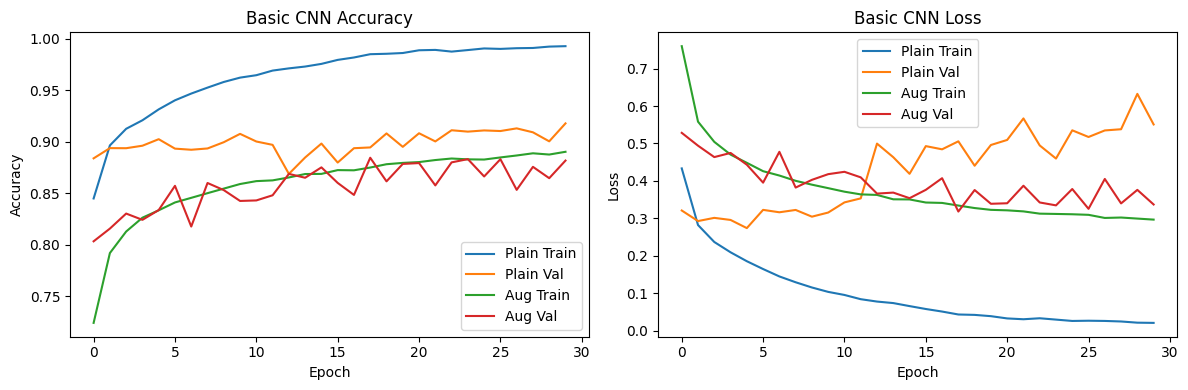

Deep CNN — with vs without augmentation


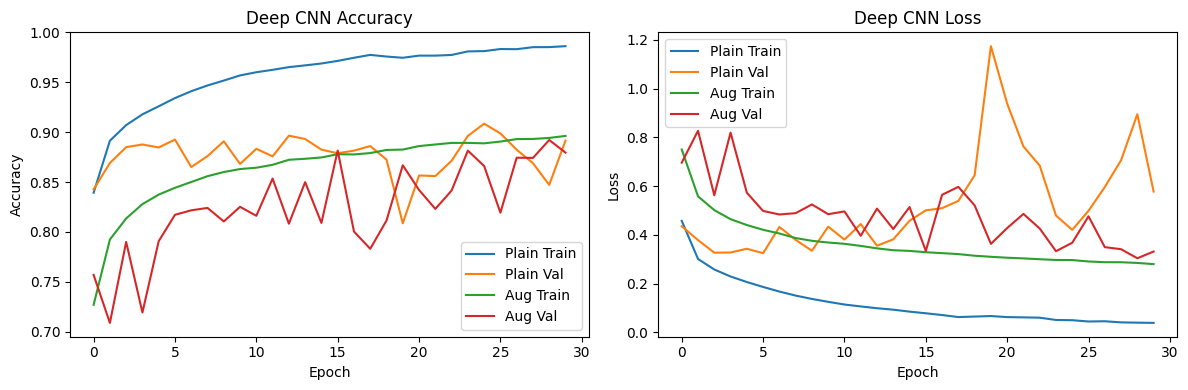

In [ ]:
# 9) Plot learning curves

print("Basic CNN — with vs without augmentation")
plot_curves(
    [artifacts["basic_plain"]["hist"], artifacts["basic_aug"]["hist"]],
    ["Plain", "Aug"],
    title="Basic CNN"
)

print("Deep CNN — with vs without augmentation")
plot_curves(
    [artifacts["deep_plain"]["hist"], artifacts["deep_aug"]["hist"]],
    ["Plain", "Aug"],
    title="Deep CNN"
)

Confusion matrix — Basic CNN without augmentation


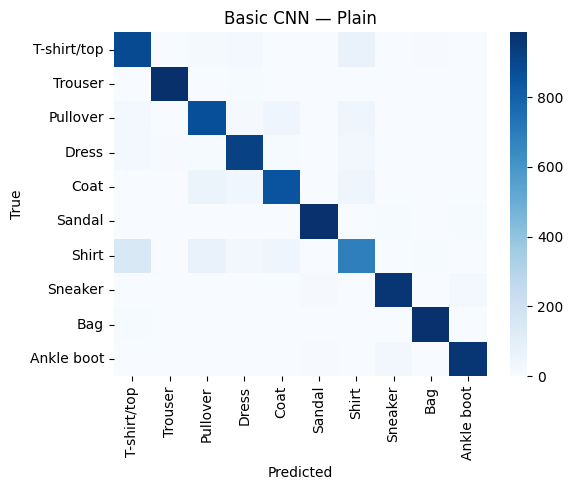

Confusion matrix — Basic CNN with augmentation


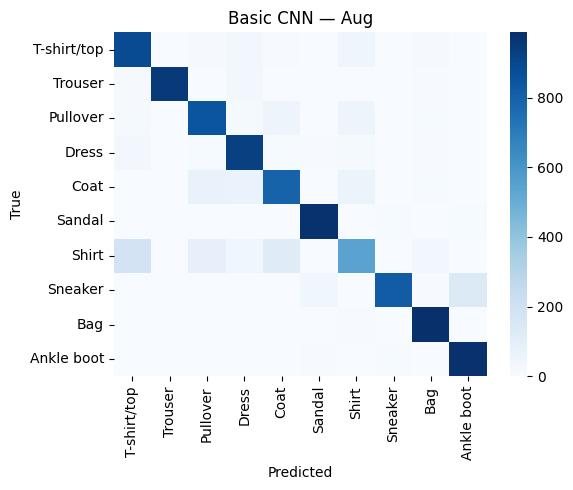

Confusion matrix — Deep CNN without augmentation


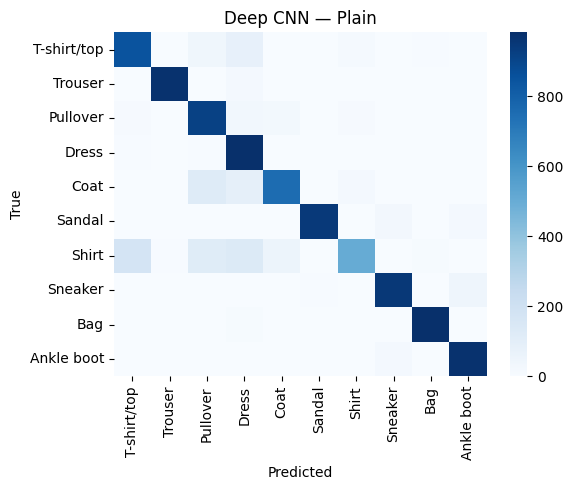

Confusion matrix — Deep CNN with augmentation


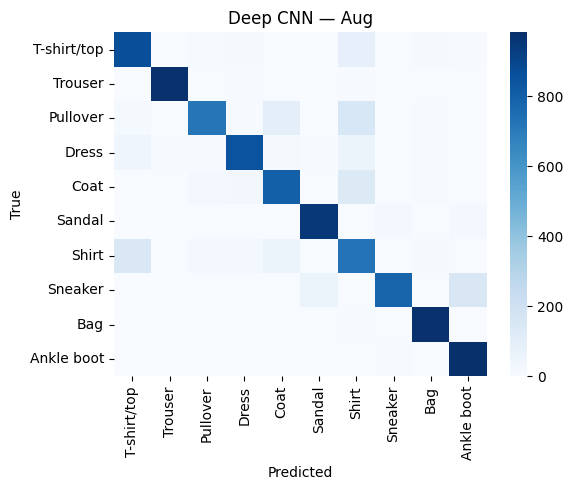

Per-class report — Deep CNN with augmentation


In [ ]:
# 10) Confusion matrices and per-class report

print("Confusion matrix — Basic CNN without augmentation")
cm_b_plain = plot_confusion(artifacts["basic_plain"]["model"], test_ds, y_test_oh,
                            title="Basic CNN — Plain")

print("Confusion matrix — Basic CNN with augmentation")
cm_b_aug = plot_confusion(artifacts["basic_aug"]["model"], test_ds, y_test_oh,
                          title="Basic CNN — Aug")

print("Confusion matrix — Deep CNN without augmentation")
cm_d_plain = plot_confusion(artifacts["deep_plain"]["model"], test_ds, y_test_oh,
                            title="Deep CNN — Plain")

print("Confusion matrix — Deep CNN with augmentation")
cm_d_aug = plot_confusion(artifacts["deep_aug"]["model"], test_ds, y_test_oh,
                          title="Deep CNN — Aug")

print("Per-class report — Deep CNN with augmentation")
y_true = np.argmax(y_test_oh, axis=1)
y_pred = np.argmax(artifacts["deep_aug"]["model"].predict(test_ds, verbose=0), axis=1)
